# Google AlphaEarth Foundations

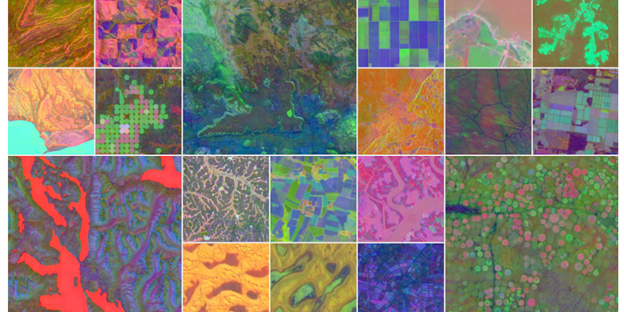

Google's AlphaEarth Foundations is a geospatial embedding model trained on multiple Earth Observation (EO) datasets. The model was run on annual time series of images, and the resulting embeddings are available as an analysis-ready dataset in Earth Engine. With this dataset, users can build any number of fine-tuning applications or other tasks without running computationally expensive deep learning models.

##Understanding Embeddings

Embeddings are a way to compress large amounts of information into a smaller set of features that represent meaningful semantics. The AlphaEarth Foundations model uses time series of sensor images, including Sentinel-2, Sentinel-1, and Landsat, and learns to uniquely represent the mutual information between sources and targets with just 64 numbers. The input data stream contains thousands of image bands from various sensors, and the model transforms this high-dimensional input into a low-dimensional representation.

A good mental model for understanding how AlphaEarth Foundations works is a technique called principal component analysis (PCA). PCA also helps reduce data dimensionality for machine learning applications. While PCA is a statistical technique and can compress dozens of input bands into a few principal components, AlphaEarth Foundations is a deep learning model that can take thousands of input dimensions from multisensor time series datasets and learn to create a 64-band representation that uniquely captures the spatial and temporal variability of that pixel.

An embedding field is the continuous matrix or "field" of learned embeddings. Images in the embedding field collections represent spatiotemporal trajectories spanning an entire year and have 64 bands (one for each embedding dimension).

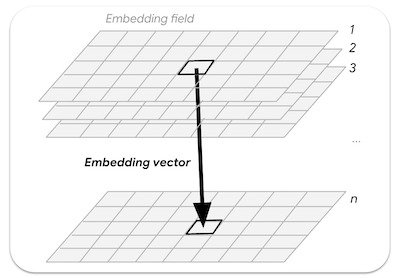

# How AlphaEarth Foundations Works

AlphaEarth Foundations offers a powerful new lens for understanding our planet, solving two major challenges: data overload and inconsistent information.

First, it combines volumes of information from dozens of different public sources—optical satellite imagery, radar, 3D laser mapping, climate simulations, and more. It weaves all this information together to analyze the world's land and coastal waters in crisp, 10 x 10 meter squares, allowing it to track changes over time with remarkable accuracy.

Second, it makes this data practical to use. The system's key innovation is its ability to create a highly compact summary for each square. These summaries require 16 times less storage space than those produced by other AI systems we tested and dramatically reduce the cost of planetary-scale analysis.

This innovation allows scientists to do something previously impossible: create detailed, consistent maps of our world, on demand. Whether monitoring crop health, tracking deforestation, or spotting new construction, they no longer need to rely on a single satellite passing overhead. Now, they have a new kind of foundation for geospatial data.

To ensure AlphaEarth Foundations was ready for real-world use, we rigorously tested its performance. When compared to traditional methods and other AI mapping systems, AlphaEarth Foundations was consistently the most accurate. It excelled at a wide range of tasks across time periods, including land use identification and surface property estimation. Crucially, it achieved this in scenarios where label data was scarce. On average, AlphaEarth Foundations had a 24% lower error rate than the models we tested, demonstrating its superior learning efficiency.

# AlphaEarth Foundations Architecture

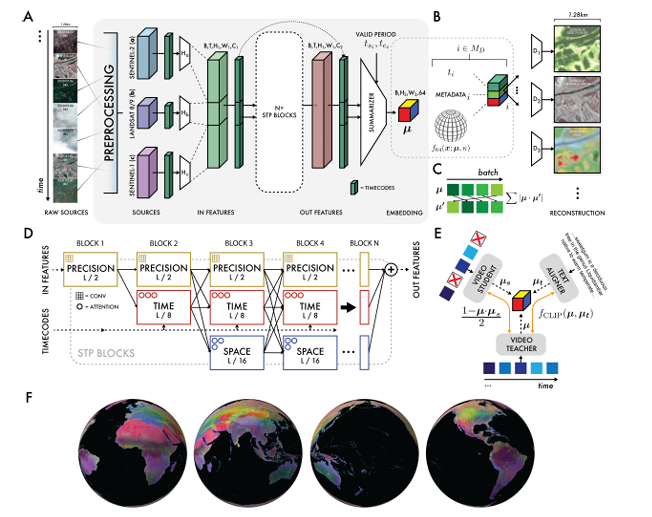

(A) Block diagram of the general architecture of the network used for video analysis. Preprocessing converts raw observation data through normalization using global statistics, and acquisition timestamps are converted to sinusoidal timecodes. Individual source encoders transform the inputs to the same latent space before inputting them to the bulk of the model. Outputs are summarized using conditional timecodes, or "summary periods," unique to each decoded source and contrastive learning task. 𝜇 refers to the model embedding outputs.

(B) Model outputs are treated as the mean direction of a von Mises-Fisher distribution, and decoding proceeds by sampling this distribution and concatenating it with sensor geometry metadata and a timecode indicating the relative position in the valid period to be decoded. Decoding proceeds for all sources, with losses dependent on the characteristics of each source.

(C) To avoid collapse and improve performance, embeddings are compared to equivalent batch-rotated embeddings using a dot product. The absolute value of this quantity is minimized as a necessary condition for an empirically uniform distribution in 𝑆63.

(D) Block diagram of the bulk model, consisting of simultaneous paths at different resolutions to maintain efficiency and spatial accuracy.

(E) Contrastive learning between the video teacher-student model and the text encoder.

(F) Full 360° view of the 2023 annual embedding field, covering the Earth's land surface, including smaller islands, to within approximately ±8

# What can we do with the Satellite Embeddings dataset?

**Similarity Search**: You can choose a point anywhere on Earth—say, on a specific type of agricultural land or forest—and instantly find and map all other locations with similar surface and environmental conditions anywhere in the world.

**Change Detection**: By comparing embedding vectors for the same pixel from different years, you can easily identify changes and track processes such as urban expansion, wildfire impacts and recovery, and fluctuating reservoir water levels.

**Automatic Clustering**: Without pre-existing labels, you can use clustering algorithms to automatically group pixels into distinct categories. This spatiotemporal segmentation can reveal hidden patterns in the landscape, differentiating various types of forests, soils, or urban development.

**Smarter Classification**: You can create accurate maps with much less training data. For example, instead of needing tens of thousands of labeled points to map crop types with more conventional inputs, you might need only a few hundred per class, saving time and computation.

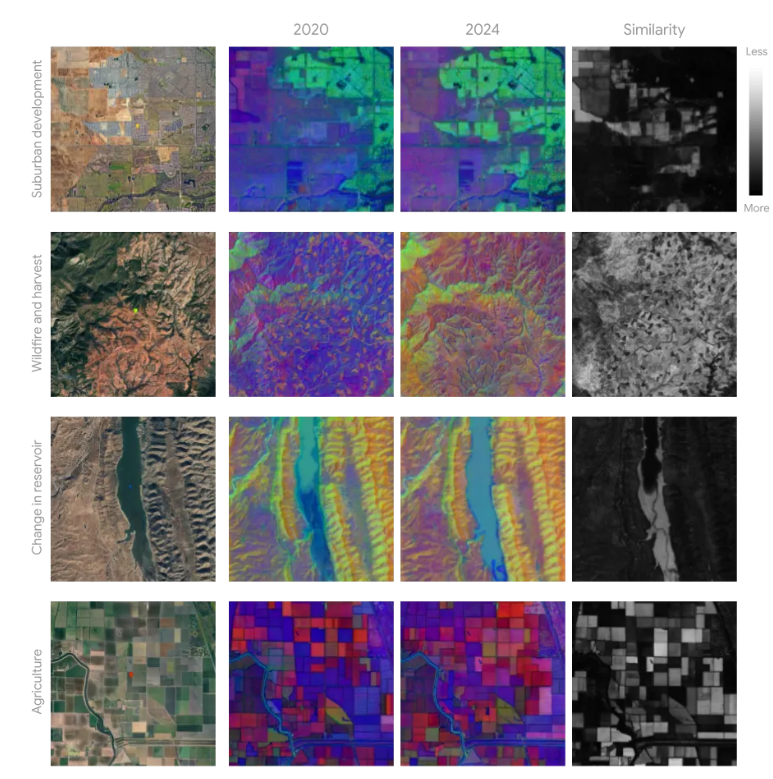

# Visualizing Embeddings using GEE and Python

Let's import GEE and the geemap library:

In [ ]:
import ee
import geemap

You need to authenticate with your own GEE project. Here I'm using mine.

In [ ]:
ee.Authenticate()
ee.Initialize(project='my-project-1527255156007')

We select the Dataset Embedding:

In [ ]:
dataset = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
point = ee.Geometry.Point([-121.8036, 39.0372])

Let's get data from 2023 and 2024. We'll also generate a similarity product between the two images:

In [ ]:
image1 = dataset \
    .filterDate('2023-01-01', '2024-01-01') \
    .filterBounds(point) \
    .first()

image2 = dataset \
    .filterDate('2024-01-01', '2025-01-01') \
    .filterBounds(point) \
    .first()


vis_params = {'min': -0.3, 'max': 0.3, 'bands': ['A01', 'A16', 'A09']}

dot_prod = image1.multiply(image2).reduce(ee.Reducer.sum())

We can then visualize a colored composition with 3 of the 64 bands:

In [ ]:
Map = geemap.Map()
Map.centerObject(point, 12)
Map.set_options('SATELLITE')

In [ ]:
Map.addLayer(image1, vis_params, '2023 embeddings')
Map.addLayer(image2, vis_params, '2024 embeddings')
Map.addLayer(dot_prod, {'min': 0, 'max': 1, 'palette': ['white', 'black']},
             'Similarity between years (brighter = less similar)')

In [ ]:
Map

Map(center=[39.0372, -121.80360000000002], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

# Clustering using Embeddings

We'll apply Embeddings to a practical clustering example. We start by selecting an area.

In [ ]:
AOI = ee.Geometry.Polygon([[[-51.829383948549825, -20.71028051938351],
                  [-51.829383948549825, -20.89899140074203],
                  [-51.477821448549825, -20.89899140074203],
                  [-51.477821448549825, -20.71028051938351]]])

Now, from the previous dataset we select our image and crop our area.

In [ ]:
image_AOI = dataset \
    .filterDate('2024-01-01', '2025-01-01') \
    .filterBounds(AOI) \
    .mosaic().clip(AOI)

We present the image:

In [ ]:
Map = geemap.Map()
Map.centerObject(AOI, 12)
Map.set_options('SATELLITE')
Map.addLayer(image_AOI, vis_params, '2024 embeddings')
Map

Map(center=[-20.80470580841122, -51.653602698549776], controls=(WidgetControl(options=['position', 'transparen…

Let's download this image with the help of the geemap library:

In [ ]:
!pip install geedim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 114.4 MB/s eta 0:00:00


In [ ]:
geemap.download_ee_image(image_AOI, 'image_AOI.tif', scale=10, crs='EPSG:4326', region=AOI)

image_AOI.tif: |          | 0.00/4.22G (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


We install rasterio and import the image as a numpy array:

In [ ]:
!pip install rasterio

In [ ]:
import rasterio
from sklearn.cluster import KMeans
import numpy as np
import geemap
import geopandas as gpd

With our area of interest, we will create 500 random points to extract the embeddings for each point and use Kmeans to cluster these points.

In [ ]:
AOI_gdf = geemap.ee_to_gdf(ee.FeatureCollection(AOI))

In [ ]:
AOI_gdf

,geometry
0,"POLYGON ((-51.82938 -20.89899, -51.47782 -20.8..."


Here we generate the random points:

In [ ]:
random_points = AOI_gdf.sample_points(size=500)

In [ ]:
random_points_gdf = random_points.explode(index_parts=False).reset_index(drop=True)

In [ ]:
random_points_gdf

,sampled_points
0,POINT (-51.82863 -20.80825)
1,POINT (-51.82754 -20.75538)
2,POINT (-51.82728 -20.77413)
3,POINT (-51.82695 -20.77285)
4,POINT (-51.8254 -20.72147)
...,...
495,POINT (-51.48195 -20.89392)
496,POINT (-51.48117 -20.77715)
497,POINT (-51.48102 -20.76665)
498,POINT (-51.48095 -20.82149)


We extract the information from the image for each point:

In [ ]:
coord_list = [(x, y) for x, y in zip(random_points_gdf.x, random_points_gdf.y)]

In [ ]:
with rasterio.open('/content/image_AOI.tif') as src:
  Values = [x for x in src.sample(coord_list)]

In [ ]:
Values = np.array(Values)

Then we apply clustering:

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit(Values)

In [ ]:
labels = clusters.predict(Values)

In [ ]:
labels

array([1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 3, 1, 3, 2, 1, 1, 1, 3,
       3, 3, 2, 3, 2, 3, 3, 3, 1, 3, 2, 1, 3, 1, 3, 3, 1, 3, 3, 1, 2, 2,
       2, 2, 2, 3, 1, 1, 2, 3, 2, 1, 3, 3, 1, 3, 3, 1, 2, 2, 3, 2, 1, 1,
       1, 1, 3, 1, 3, 2, 1, 2, 1, 1, 2, 3, 2, 3, 1, 2, 2, 2, 1, 1, 2, 2,
       2, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 4, 2, 2, 2, 1, 2, 2, 2, 3, 4, 4,
       2, 2, 1, 2, 2, 3, 2, 3, 1, 1, 2, 4, 2, 3, 3, 3, 2, 2, 2, 2, 4, 4,
       1, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 4, 2, 2, 4, 3, 3, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 3, 2, 3, 2,
       4, 4, 3, 4, 2, 4, 3, 4, 1, 3, 2, 2, 2, 2, 0, 3, 3, 2, 2, 4, 4, 2,
       4, 2, 4, 3, 0, 3, 0, 3, 2, 3, 3, 3, 2, 3, 0, 2, 3, 3, 3, 2, 2, 0,
       0, 2, 0, 3, 2, 0, 0, 2, 0, 0, 3, 3, 2, 0, 0, 2, 0, 0, 3, 0, 0, 0,
       4, 0, 0, 0, 1, 0, 0, 3, 0, 3, 0, 0, 0, 3, 3, 3, 3, 0, 3, 2, 0, 2,
       2, 3, 0, 0, 3, 1, 3, 0, 0, 0, 0, 2, 0, 3, 0,

With the algorithm trained, we will apply clustering to all pixels in the image we downloaded:

In [ ]:
with rasterio.open('/content/image_AOI.tif') as src:
  img_emb = src.read()

In [ ]:
img_emb = img_emb.transpose([1,2,0])

In [ ]:
l,c,b = img_emb.shape

We convert the image to a vector of pixels

In [ ]:
img_emb_vec = img_emb.reshape(l*c, b)

We remove infinite values:

In [ ]:
img_emb_vec[~np.isfinite(img_emb_vec)] = 0

We apply clustering

In [ ]:
clustered_image = clusters.predict(img_emb_vec)

Finally, we convert the prediction vector into an image, display it as matplotlib, and save it to a .tif file.

In [ ]:
clustered_image = clustered_image.reshape(l, c)

In [ ]:
np.unique(clustered_image)

array([0, 1, 2, 3, 4], dtype=int32)

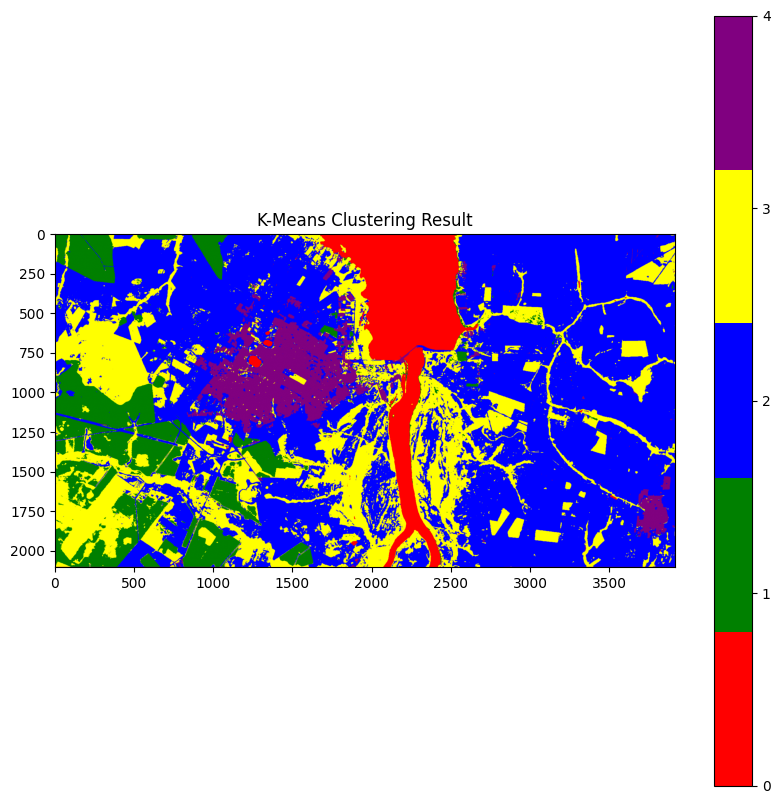

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a colormap with 5 colors
cmap = ListedColormap(['red', 'green', 'blue', 'yellow', 'purple'])

# Plot the clustered image
plt.figure(figsize=(10, 10))
plt.imshow(clustered_image, cmap=cmap)
plt.title('K-Means Clustering Result')
plt.colorbar(ticks=range(n_clusters))
plt.show()

In [ ]:
with rasterio.open('/content/image_AOI.tif') as src:
  profile = src.profile

profile.update(
    dtype=rasterio.uint8,
    count=1,
    nodata= None,
    compress='lzw')

with rasterio.open('clustered_image.tif', 'w', **profile) as dst:
  dst.write(clustered_image.astype(rasterio.uint8), 1)